<a href="https://colab.research.google.com/github/susannadluca/projet_hns_topurbi/blob/main/Copia_UFFICIALE_di_projet_hns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Rendu final – Humanités Numériques Spatialisées
# Cartographie des lieux à partir de l’index TopUrbi (dictionnaire d’Alcedo)
# Susanna De Luca – Master 2 HN – Janvier 2026


In [ ]:
#vérifie que le fichier est correctement chargé

with open("TopUrbiIndex.xml", "r", encoding="utf-8") as f:
    print(f.readline())


<?xml version="1.0" encoding="UTF-8"?>



In [ ]:
# Import de la bibliothèque lxml.etree
# La bibliothèque lxml est utilisée pour le traitement et l’analyse de fichiers XML

!pip -q install lxml

from lxml import etree

tree = etree.parse("TopUrbiIndex.xml")
root = tree.getroot()

places = root.xpath("//*[local-name()='place']")
print("Numero di <place> trovati:", len(places))

# affiche un exemple d'identifiant et de nom pour vérifier que tout est correct

first = places[0]
place_id = first.get("{http://www.w3.org/XML/1998/namespace}id") or first.get("xml:id") or first.get("id")
name_el = first.xpath(".//*[local-name()='placeName'][1]")
place_name = name_el[0].text.strip() if name_el and name_el[0].text else None

print("Esempio:", place_id, "-", place_name)


Numero di <place> trovati: 17725
Esempio: TopUrbiPlace29305 - Sambalas


In [ ]:
# Construction du dataset à partir de l’index TopUrbi

import pandas as pd
import re
from lxml import etree

def parse_geo(geo_text: str):
    """Convertit '8,1318 -80,959' -> (8.1318, -80.959). Retourne (None, None) si vide/invalide."""
    if not geo_text:
        return None, None
    t = geo_text.strip().replace(",", ".")
    parts = re.split(r"\s+", t)
    if len(parts) < 2:
        return None, None
    try:
        return float(parts[0]), float(parts[1])
    except ValueError:
        return None, None

def safe_text(el):
    return (el.text or "").strip() if el is not None else None

# Re-parse
tree = etree.parse("TopUrbiIndex.xml")
root = tree.getroot()

places = root.xpath("//*[local-name()='place']")

rows = []
for p in places:
    # ID du lieu
    place_id = (
        p.get("{http://www.w3.org/XML/1998/namespace}id")
        or p.get("xml:id")
        or p.get("id")
    )

    # Nom du lieu
    placeName_el = p.xpath(".//*[local-name()='placeName'][1]")
    place_name = safe_text(placeName_el[0]) if placeName_el else None

    # Type de "branche" (ex: settlement, geogName@type)
    # - si <settlement> existe => settlement
    # - sinon, si <geogName type="..."> => geogName:<type>
    branch_type = None
    if p.xpath(".//*[local-name()='settlement'][1]"):
        branch_type = "settlement"
    else:
        geog = p.xpath(".//*[local-name()='geogName'][1]")
        if geog:
            gt = geog[0].get("type")
            branch_type = f"geogName:{gt}" if gt else "geogName"

    # Feature type (contenu de <term type="featuretype">)
    term_el = p.xpath(".//*[local-name()='term' and @type='featuretype'][1]")
    feature_type = safe_text(term_el[0]) if term_el else None

    # District et région (conteneurs)
    district_el = p.xpath(".//*[local-name()='district'][1]")
    district = safe_text(district_el[0]) if district_el else None

    region_el = p.xpath(".//*[local-name()='region'][1]")
    region = safe_text(region_el[0]) if region_el else None

    # Représentation de localisation (well_placed, provincial dummy, etc.)
    loc_repr_el = p.xpath(".//*[local-name()='note' and @type='location_representation'][1]")
    location_representation = safe_text(loc_repr_el[0]) if loc_repr_el else None

    # Coordonnées (geo)
    geo_el = p.xpath(".//*[local-name()='geo'][1]")
    geo_text = safe_text(geo_el[0]) if geo_el else None
    lat, lon = parse_geo(geo_text)

    # Lien vers le contexte dans le volume
    entry_link_el = p.xpath(".//*[local-name()='link' and @type='entry'][1]")
    entry_target = entry_link_el[0].get("target") if entry_link_el else None

    # Statut de review (si disponible, on prend la note FR/EN/ES la première trouvée)
    review_el = p.xpath(".//*[local-name()='note' and @type='review'][1]")
    review_note = safe_text(review_el[0]) if review_el else None

    rows.append({
        "place_id": place_id,
        "place_name": place_name,
        "branch_type": branch_type,
        "feature_type": feature_type,
        "district": district,
        "region": region,
        "location_representation": location_representation,
        "lat": lat,
        "lon": lon,
        "entry_target": entry_target,
        "review_note": review_note
    })

df = pd.DataFrame(rows)

print("Righe totali (luoghi):", len(df))
print("Colonne:", list(df.columns))
df.head(10)


Righe totali (luoghi): 17725
Colonne: ['place_id', 'place_name', 'branch_type', 'feature_type', 'district', 'region', 'location_representation', 'lat', 'lon', 'entry_target', 'review_note']


,place_id,place_name,branch_type,feature_type,district,region,location_representation,lat,lon,entry_target,review_note
0,TopUrbiPlace29305,Sambalas,geogName:natural_feature,Bahía,Darien,Tierra Firme,provincial dummy coordinates.,7.9788,-77.9131,Alcedo_vol_4.xml#id_14617a,Este lugar no ha sido revisado.
1,TopUrbiPlace10001,Abbots,geogName:natural_feature,Rio,North Carolina,USA,provincial dummy coordinates.,35.2253,-77.5081,Alcedo_vol_1.xml#id_00005,Este lugar no ha sido revisado.
2,TopUrbiPlace10002,Abacachis,settlement,Pueblo de Indios,Amazonas,Brasil,automatic.,-3.1474,-58.4461,Alcedo_vol_1.xml#id_00006,Este lugar ha sido revisado.
3,TopUrbiPlace10004,Abacqua,settlement,Pueblo,Rio de la Plata,Rio de la Plata,sufficient.,-27.3221,-58.5356,Alcedo_vol_1.xml#id_00008,La identificación de este lugar es probable pe...
4,TopUrbiPlace10005,Abacu,geogName:natural_feature,Punta,Santo Domingo,Santo Domingo,provincial dummy coordinates.,19.0661,-70.5867,Alcedo_vol_1.xml#id_00009,Este lugar no ha sido revisado.
5,TopUrbiPlace10006,Abades,settlement,Pueblo,Popayan,Quito-Popayan,sufficient.,2.2919,-76.8272,Alcedo_vol_1.xml#id_00010,La identificación de este lugar es probable pe...
6,TopUrbiPlace10007,Abancay,None,Provincia,,Peru,auto.,-13.5351,-72.5586,Alcedo_vol_1.xml#id_00011,Este lugar ha sido revisado.
7,TopUrbiPlace10008,Abancai,settlement,Pueblo,,-,well_placed.,-13.6333,-72.8833,Alcedo_vol_1.xml#id_00012,Este lugar ha sido revisado.
8,TopUrbiPlace10009,Abancay,settlement,Pueblo,Cuenca,Quito-Popayan,well_placed.,-2.8237,-78.8876,Alcedo_vol_1.xml#id_00013,Este lugar ha sido revisado.
9,TopUrbiPlace10011,Abangoui,settlement,Pueblo,Rio de la Plata,Rio de la Plata,sufficient.,-29.3377,-59.2910,Alcedo_vol_1.xml#id_00015,La identificación de este lugar es probable pe...


In [ ]:
# Création d’un sous-ensemble de données contenant uniquement
# les lieux pour lesquels des coordonnées géographiques sont disponibles.
# Cette étape est indispensable pour la cartographie.

df_geo = df.dropna(subset=["lat", "lon"]).copy()

# Classification des lieux selon la précision de leur localisation
# (localisation attestée vs localisation approximative).
def precision_cat(x):
    x = (x or "").lower()
    if "well_placed" in x:
        return "well_placed"
    if "provincial" in x or "dummy" in x:
        return "provincial_dummy"
    return "other/unknown"

df_geo["precision_cat"] = df_geo["location_representation"].apply(precision_cat)

print("Luoghi con coordinate:", len(df_geo))
print(df_geo["precision_cat"].value_counts())


Luoghi con coordinate: 17714
precision_cat
provincial_dummy    8467
well_placed         5981
other/unknown       3266
Name: count, dtype: int64


In [ ]:
# Préparation de l’environnement pour la cartographie statique
# Elle repose sur l’utilisation de GeoPandas et Matplotlib, outils adaptés à la représentation cartographique contrôlée de grands territoires
!pip -q install geopandas shapely pyproj matplotlib

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point


In [ ]:
# Conversion du DataFrame (df_geo) en GeoDataFrame pour la cartographie
# Chaque lieu devient un point géographique (lon, lat) en WGS84 (EPSG:4326).
gdf = gpd.GeoDataFrame(
    df_geo.copy(),
    geometry=gpd.points_from_xy(df_geo["lon"], df_geo["lat"]),
    crs="EPSG:4326"
)

print("GeoDataFrame OK")
print("Righe:", len(gdf))
print("CRS:", gdf.crs)
gdf[["place_name", "precision_cat", "feature_type", "district", "region", "geometry"]].head(3)


GeoDataFrame OK
Righe: 17714
CRS: EPSG:4326


,place_name,precision_cat,feature_type,district,region,geometry
0,Sambalas,provincial_dummy,Bahía,Darien,Tierra Firme,POINT (-77.9131 7.9788)
1,Abbots,provincial_dummy,Rio,North Carolina,USA,POINT (-77.5081 35.2253)
2,Abacachis,other/unknown,Pueblo de Indios,Amazonas,Brasil,POINT (-58.4461 -3.1474)


In [ ]:
# Fond de carte : frontières des pays (Natural Earth, résolution 110m)
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip")

print("Basemap OK")
print("Paesi:", len(world))
world.head(2)


Basemap OK
Paesi: 177


,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,None,None,None,None,None,None,None,None,None,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."


In [ ]:
# Découpage approximatif des Amériques (lon/lat)
americas = world.cx[-170:-20, -60:75]

print("Americas OK")
print("Paesi nel ritaglio:", len(americas))
americas[["ADMIN", "geometry"]].head(5)


Americas OK
Paesi nel ritaglio: 34


,ADMIN,geometry
3,Canada,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,United States of America,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."
9,Argentina,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25 -5..."
10,Chile,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335..."
16,Haiti,"POLYGON ((-71.71236 19.71446, -71.62487 19.169..."


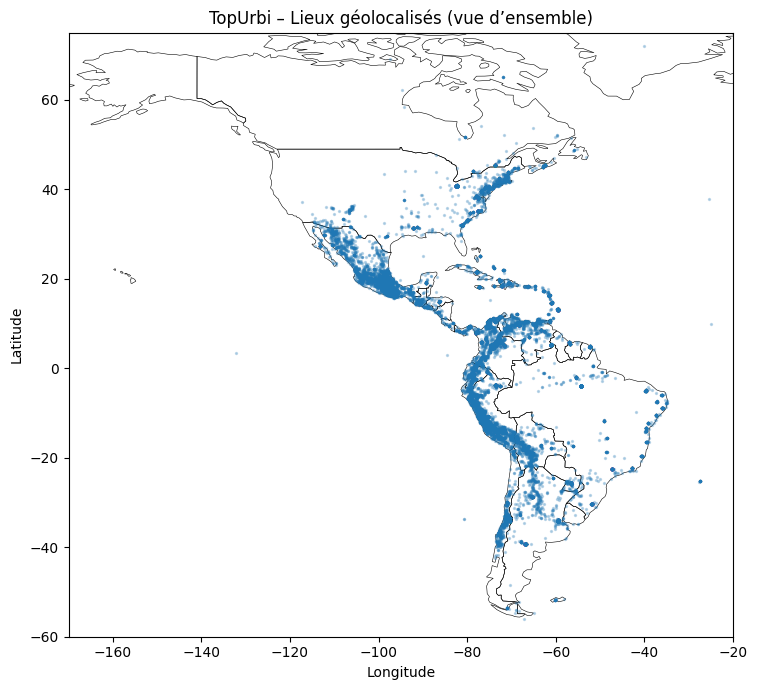

In [ ]:
# CARTE 1 — Vue d’ensemble : tous les lieux géolocalisés (17 714 points)
# Objectif : situer le corpus à l’échelle continentale (Amériques) et visualiser la couverture spatiale.

fig, ax = plt.subplots(figsize=(12, 7))

# Fond : pays (Amériques)
americas.plot(ax=ax, linewidth=0.4, edgecolor="black", facecolor="none")

# Points : tous les lieux
gdf.plot(ax=ax, markersize=2, alpha=0.25)

ax.set_title("TopUrbi – Lieux géolocalisés (vue d’ensemble)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim(-170, -20)
ax.set_ylim(-60, 75)

plt.tight_layout()
plt.show()


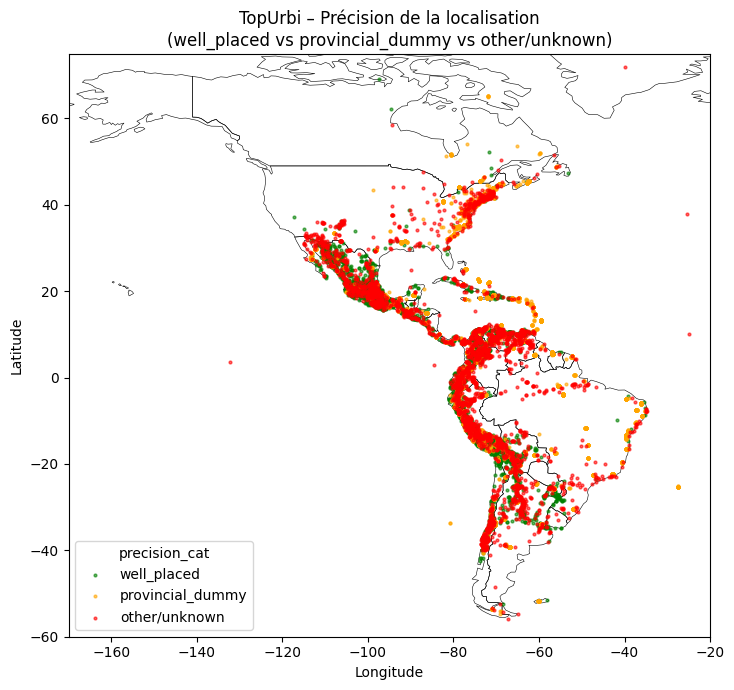

In [ ]:
# CARTE 2 — Précision de la localisation (carte clé)
# Objectif : comparer visuellement les lieux "well_placed" (localisation attestée)
# et les lieux à coordonnées indicatives ("provincial_dummy") ainsi que les cas "other/unknown".

fig, ax = plt.subplots(figsize=(12, 7))

# Fond de carte (Amériques)
americas.plot(ax=ax, linewidth=0.4, edgecolor="black", facecolor="none")

# Tracer chaque catégorie séparément (pour avoir une légende propre)
cats = ["well_placed", "provincial_dummy", "other/unknown"]
colors = {
    "well_placed": "green",
    "provincial_dummy": "orange",
    "other/unknown": "red",
}

for c in cats:
    subset = gdf[gdf["precision_cat"] == c]
    subset.plot(ax=ax, markersize=4, alpha=0.6, color=colors[c], label=c)

ax.set_title("TopUrbi – Précision de la localisation\n(well_placed vs provincial_dummy vs other/unknown)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim(-170, -20)
ax.set_ylim(-60, 75)

ax.legend(title="precision_cat", loc="lower left", frameon=True)

plt.tight_layout()
plt.show()


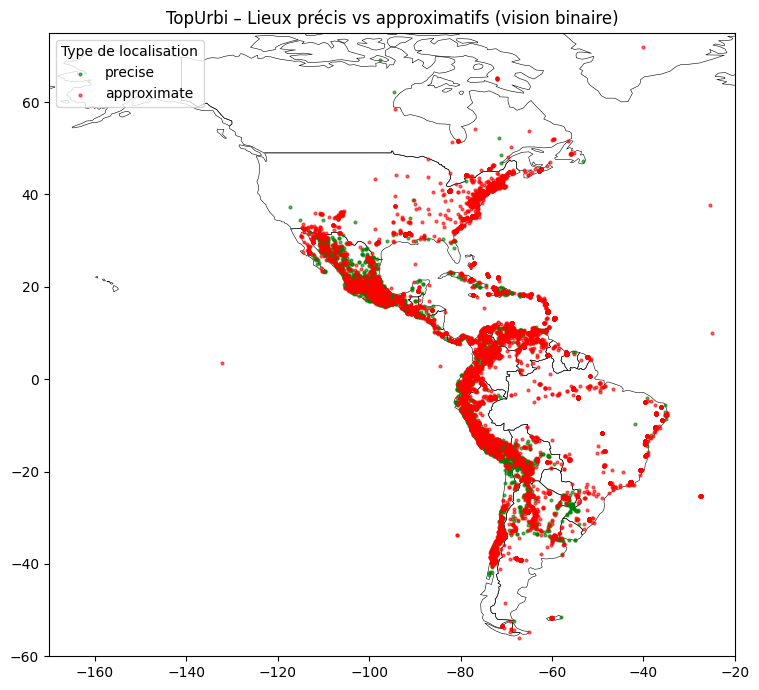

In [ ]:
# CARTE 3 — Lieux précisément localisés vs approximatifs

fig, ax = plt.subplots(figsize=(12, 7))

americas.plot(ax=ax, linewidth=0.4, edgecolor="black", facecolor="none")

gdf["precision_binary"] = gdf["precision_cat"].apply(
    lambda x: "precise" if x == "well_placed" else "approximate"
)

colors = {"precise": "green", "approximate": "red"}

for cat, col in colors.items():
    subset = gdf[gdf["precision_binary"] == cat]
    subset.plot(ax=ax, markersize=4, alpha=0.6, color=col, label=cat)

ax.set_title("TopUrbi – Lieux précis vs approximatifs (vision binaire)")
ax.set_xlim(-170, -20)
ax.set_ylim(-60, 75)
plt.legend(title="Type de localisation")
plt.tight_layout()
plt.show()


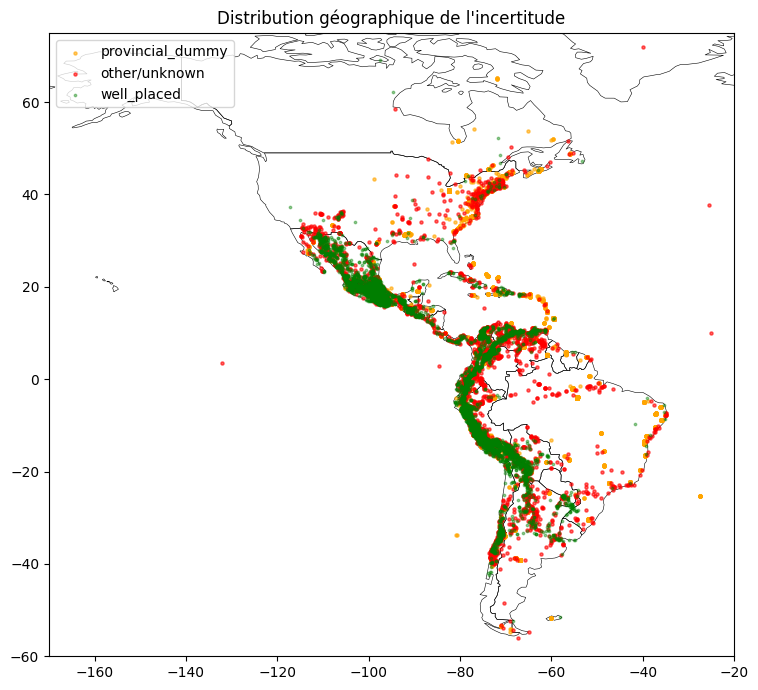

In [ ]:
# CARTE 4 — Distribution géographique de l'incertitude

fig, ax = plt.subplots(figsize=(12, 7))
americas.plot(ax=ax, linewidth=0.4, edgecolor="black", facecolor="none")

# Points incertains

gdf[gdf["precision_cat"] == "provincial_dummy"].plot(
    ax=ax, markersize=5, color="orange", alpha=0.6, label="provincial_dummy"
)

gdf[gdf["precision_cat"] == "other/unknown"].plot(
    ax=ax, markersize=5, color="red", alpha=0.6, label="other/unknown"
)

# Points précis pour comparaison

gdf[gdf["precision_cat"] == "well_placed"].plot(
    ax=ax, markersize=3, color="green", alpha=0.4, label="well_placed"
)

ax.set_title("Distribution géographique de l'incertitude")
ax.set_xlim(-170, -20)
ax.set_ylim(-60, 75)
plt.legend()
plt.tight_layout()
plt.show()


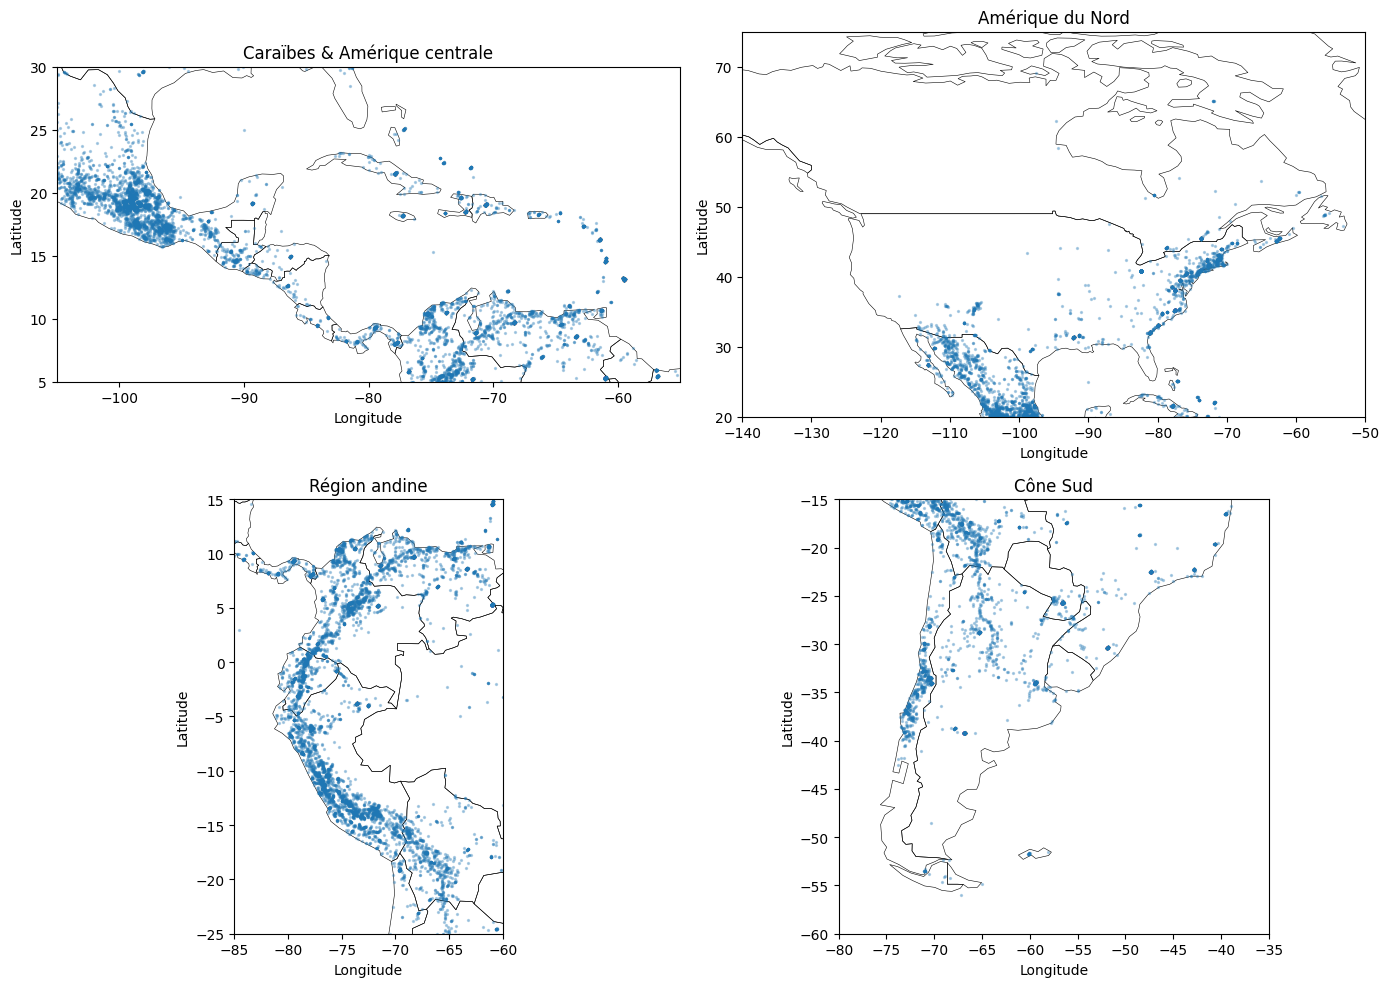

In [ ]:
# CARTE 5 — Découpage / zoom regionali (small multiples)
# Objectif : améliorer la lisibilité en travaillant par sous-régions à l’échelle des Amériques.

regions = {
    "Caraïbes & Amérique centrale": {"xlim": (-105, -55), "ylim": (5, 30)},
    "Amérique du Nord": {"xlim": (-140, -50), "ylim": (20, 75)},
    "Région andine": {"xlim": (-85, -60), "ylim": (-25, 15)},
    "Cône Sud": {"xlim": (-80, -35), "ylim": (-60, -15)},
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, (title, bbox) in zip(axes, regions.items()):
    # Fond (même couche Amériques, mais zoom avec limites)
    americas.plot(ax=ax, linewidth=0.4, edgecolor="black", facecolor="none")

    # Points
    gdf.plot(ax=ax, markersize=2, alpha=0.30)

    ax.set_title(title)
    ax.set_xlim(*bbox["xlim"])
    ax.set_ylim(*bbox["ylim"])
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()


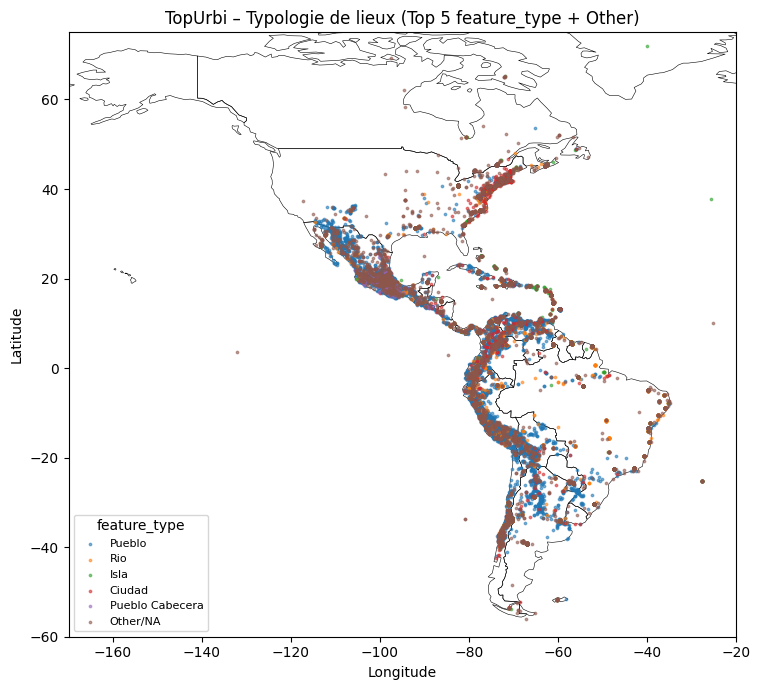

Top feature_type:
feature_type
Pueblo              7632
Rio                 3555
Isla                 758
Ciudad               698
Pueblo Cabecera      378
Provincia            367
Punta                329
Puerto               319
Bahía                277
Pueblo de Indios     272
Name: count, dtype: int64


In [ ]:
# CARTE 6 — Typologie de lieux (feature_type) : top catégories
# Objectif : visualiser la répartition spatiale des principaux types de lieux.

# Top N feature_type (escludiamo i missing)
top_n = 5
top_types = gdf["feature_type"].dropna().value_counts().head(top_n).index.tolist()

# on crée une colonne avec "Other" pour tout ce qui n'est pas dans top_types
gdf["feature_top"] = gdf["feature_type"].where(gdf["feature_type"].isin(top_types), other="Other/NA")

fig, ax = plt.subplots(figsize=(12, 7))
americas.plot(ax=ax, linewidth=0.4, edgecolor="black", facecolor="none")

# Plot par catégories (une à la fois pour une légende claire)
cats = top_types + ["Other/NA"]

for c in cats:
    subset = gdf[gdf["feature_top"] == c]
    subset.plot(ax=ax, markersize=3, alpha=0.55, label=c)

ax.set_title(f"TopUrbi – Typologie de lieux (Top {top_n} feature_type + Other)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim(-170, -20)
ax.set_ylim(-60, 75)

ax.legend(title="feature_type", loc="lower left", frameon=True, fontsize=8)
plt.tight_layout()
plt.show()

print("Top feature_type:")
print(gdf["feature_type"].value_counts().head(10))


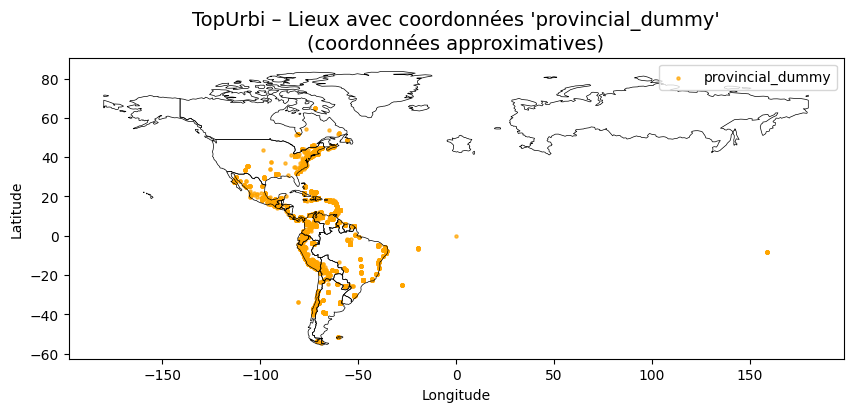

In [ ]:
# CARTE 7 – Lieux provincial_dummy (coordonnées approximatives)


dummy = gdf[gdf["precision_cat"] == "provincial_dummy"]

fig, ax = plt.subplots(figsize=(10, 10))

# Fond de carte delle Americhe
americas.boundary.plot(ax=ax, color="black", linewidth=0.5)

# Points dummy
dummy.plot(
    ax=ax,
    markersize=5,
    color="orange",
    alpha=0.7,
    label="provincial_dummy"
)

# Titolo e assi
ax.set_title("TopUrbi – Lieux avec coordonnées 'provincial_dummy'\n(coordonnées approximatives)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

plt.show()


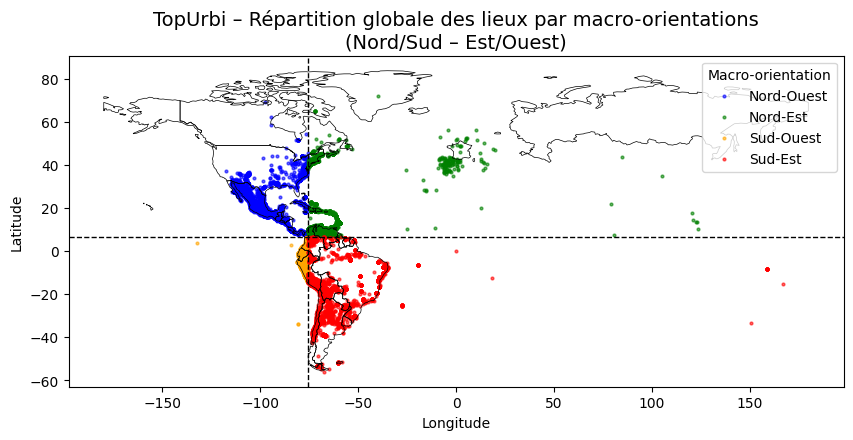

In [ ]:
#CARTE 8 – Comparaison par grandes orientations géographiques
# (Nord/Sud – Est/Ouest)

# Calcul des moyennes (latitude / longitude) pour tracer les lignes de séparation
mean_lat = gdf.geometry.y.mean()
mean_lon = gdf.geometry.x.mean()

fig, ax = plt.subplots(figsize=(10, 10))

# Fond de carte : limites des pays des Amériques
americas.boundary.plot(ax=ax, color="black", linewidth=0.5)

# Définition des 4 macro-régions
quadrants = [
    ("Nord-Ouest", gdf[(gdf.geometry.y >= mean_lat) & (gdf.geometry.x < mean_lon)], "blue"),
    ("Nord-Est",   gdf[(gdf.geometry.y >= mean_lat) & (gdf.geometry.x >= mean_lon)], "green"),
    ("Sud-Ouest",  gdf[(gdf.geometry.y < mean_lat)  & (gdf.geometry.x < mean_lon)], "orange"),
    ("Sud-Est",    gdf[(gdf.geometry.y < mean_lat)  & (gdf.geometry.x >= mean_lon)], "red"),
]

# Tracé des points par macro-orientation
for nom, sous_ensemble, couleur in quadrants:
    sous_ensemble.plot(
        ax=ax,
        markersize=4,
        alpha=0.6,
        color=couleur,
        label=nom
    )

# Lignes de séparation Nord/Sud et Est/Ouest
ax.axhline(mean_lat, color="black", linestyle="--", linewidth=1)
ax.axvline(mean_lon, color="black", linestyle="--", linewidth=1)

# Titres et axes
ax.set_title(
    "TopUrbi – Répartition globale des lieux par macro-orientations\n(Nord/Sud – Est/Ouest)",
    fontsize=14
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(title="Macro-orientation")

plt.show()


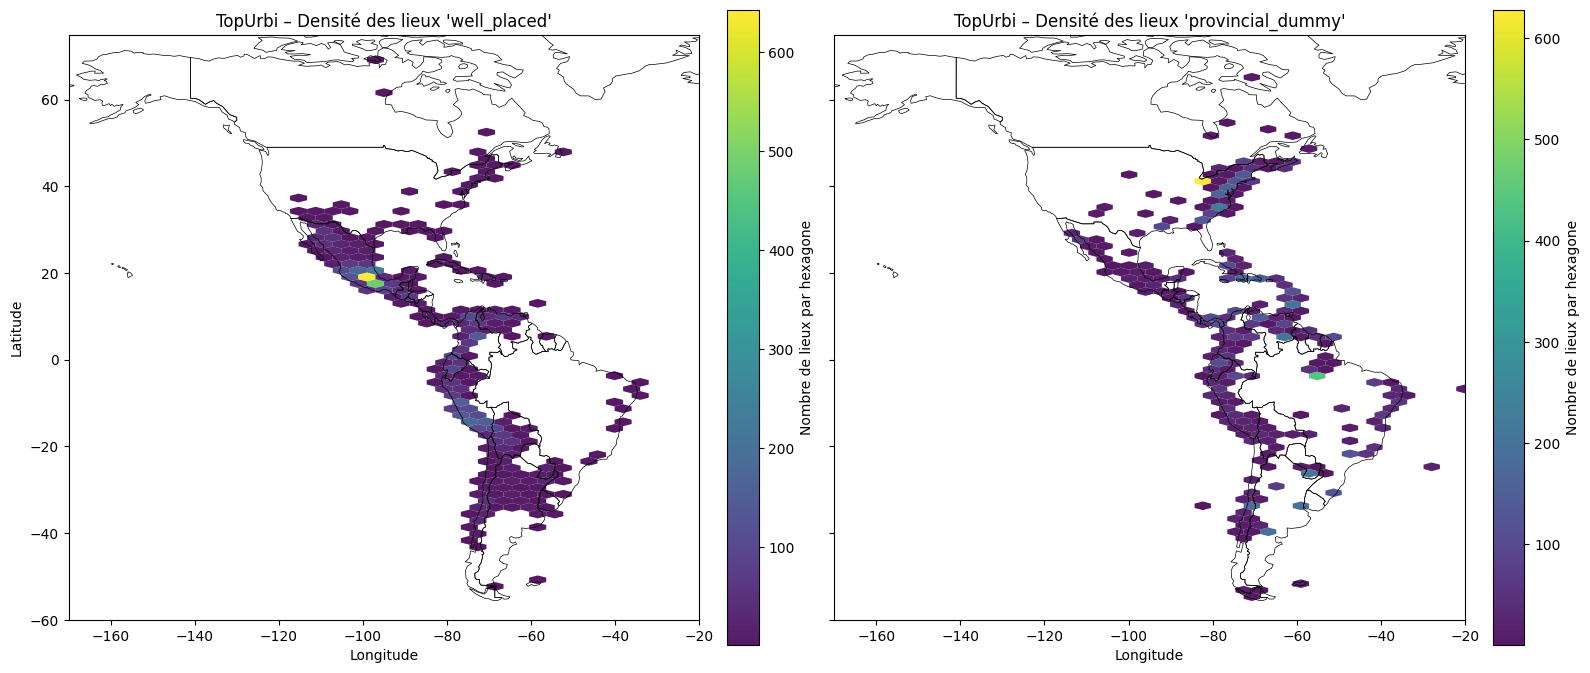

well_placed: 5981 | provincial_dummy: 8467


In [ ]:
#CARTE 9 – Carte exploratoire : densité comparée selon la précision
# (well_placed vs provincial_dummy)
# Objectif : montrer comment l'incertitude modifie la lecture spatiale du corpus.

g_well = gdf[gdf["precision_cat"] == "well_placed"]
g_dummy = gdf[gdf["precision_cat"] == "provincial_dummy"]

fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)

# Panneau 1 : well_placed
americas.boundary.plot(ax=axes[0], color="black", linewidth=0.5)
hb1 = axes[0].hexbin(
    g_well.geometry.x, g_well.geometry.y,
    gridsize=70, mincnt=1, linewidths=0, alpha=0.9
)
axes[0].set_title("TopUrbi – Densité des lieux 'well_placed'")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# Panneau 2 : provincial_dummy
americas.boundary.plot(ax=axes[1], color="black", linewidth=0.5)
hb2 = axes[1].hexbin(
    g_dummy.geometry.x, g_dummy.geometry.y,
    gridsize=70, mincnt=1, linewidths=0, alpha=0.9
)
axes[1].set_title("TopUrbi – Densité des lieux 'provincial_dummy'")
axes[1].set_xlabel("Longitude")

# Limites identiques (pour comparer correctement)
for ax in axes:
    ax.set_xlim(-170, -20)
    ax.set_ylim(-60, 75)

# Deux barres de couleur (une par panneau) : clair et honnête
cb1 = fig.colorbar(hb1, ax=axes[0], fraction=0.046, pad=0.04)
cb1.set_label("Nombre de lieux par hexagone")
cb2 = fig.colorbar(hb2, ax=axes[1], fraction=0.046, pad=0.04)
cb2.set_label("Nombre de lieux par hexagone")

plt.tight_layout()
plt.show()

print("well_placed:", len(g_well), "| provincial_dummy:", len(g_dummy))
